In [1]:
!pip install strands-agents[mistral] python-dotenv sentence_transformers scikit-learn k-means-constrained

  Using cached httpx-0.28.1-py3-none-any.whl.metadata (7.1 kB)
  Using cached httpcore-1.0.9-py3-none-any.whl.metadata (21 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 142.6 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.0/12.0 MB 225.8 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 564.3/564.3 kB 66.1 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 198.4 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 183.6 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 138.9 MB/s  0:00:00
Using cached httpx-0.28.1-py3-none-any.whl (73 kB)
Using cached httpcore-1.0.9-py3-none-any.whl (78 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.8/16.8 MB 244.4 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 28.1/28.1 MB 217.7 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 766.7/766.7 MB 20.0 MB/s  0:00:17m0:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 33.8 MB/s 

In [20]:
import json
import os
import sys
import dotenv
import numpy as np
import re

import ast

import yaml
from pathlib import Path, PosixPath
from typing import Dict, List, Tuple, TypeVar
from tqdm import tqdm

from collections import Counter

from sentence_transformers import SentenceTransformer

import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from k_means_constrained import KMeansConstrained
from sklearn.metrics import silhouette_score

from collections import defaultdict

from sklearn.feature_extraction.text import TfidfVectorizer

# Pydantic for structured data
from pydantic import BaseModel, Field

# Strands for AI agents
from strands.agent import Agent
from strands.models.mistral import MistralModel

from collections import Counter

sys.path.append('..')

from src.utils import (
    save_json,
    read_json,
    load_file_content,
    get_job_paths,
    get_training_paths,
    sanity_check,
	chat_with_persona,
    track_api_call,  # Cost tracking from utils
    print_cost_summary,  # Cost summary from utils
    reset_cost_tracker  # Reset cost tracker from utils
)

from src.my_utils import (
    display_markdown_file,
    call_mistral,
    get_agent,
    batch_extract,
    compute_stat_for_multi_items
)

from src.models.skill_domain_info import SkillDomainInfo
from src.models.training_info import (
    TrainingInfo
)
from src.models.job_info import (
    JobInfo,
    JobInforequired_skills_domains
)
from src.prompts.skill_domain_extraction_prompt import (
    SKILL_DOMAIN_EXTRACTION_PROMPT,
    DOMAIN_MATCHING_PROMPT,
    SKILL_DOMAIN_EXTENSION_PROMPT,
    JOB_SKILL_DOMAINS_CLASSIFICATION_PROMPT
)
from src.prompts.training_extraction_prompt import EXTENDED_TRAINING_EXTRACTION_PROMPT

# Load API key from .env file
dotenv.load_dotenv("../env")

# Check if we're good to go
if not os.getenv("MISTRAL_API_KEY"):
    print("❌ No MISTRAL_API_KEY found!")
    print("Create an env file with your API key")
else:
    print("✅ API key found, we're ready to roll")

ModuleNotFoundError: No module named 'sentence_transformers'

In [21]:
DATA_JOBS_DIR = Path('../data_jobs')

In [22]:
with open("../src/config.yaml", "r") as f:
    config = yaml.safe_load(f)

job_data_version = config["job_data_version"]
print(f"job_data_version version: {job_data_version}")

job_data_version version: v4


In [23]:
# Load jobs data
filename = f"extracted_jobs_{job_data_version}.json"
jobs_save_path = DATA_JOBS_DIR / filename
jobs_data = read_json(jobs_save_path)

# Convert to JobInfo objects
jobs_info = {
    job_id: JobInfo.model_validate_json(data)
    for job_id, data in jobs_data.items()
}

print(f"✅ Loaded {len(jobs_info)} jobs")
print("\n" + "="*50)

NameError: name 'JobInfo' is not defined

In [5]:
# Load job descriptions
job_descriptions = {}
job_paths = get_job_paths()
for path in tqdm(job_paths):
    id_ = path.stem
    text = load_file_content(path)
    job_descriptions[id_]=text

# print(training_descriptions)

NameError: name 'get_job_paths' is not defined

# Define functions

In [27]:
def generate_embeddings(items_list):
    model = SentenceTransformer('all-MiniLM-L6-v2')
    embeddings = model.encode(items_list, show_progress_bar=True)
    return embeddings

In [28]:
def find_optimal_clusters_random(
    embeddings,
    max_k=15,
    n_init_passes=5,
    algo='KMeans',
    size_max=3
):
    best_silhouette_scores = []
    best_labels_per_k = {}
    best_kmeans_models = {}
    
    min_k = 2
    if algo == 'KMeansConstrained':
        min_k = int(math.ceil(len(embeddings) / size_max))
    
    for k in tqdm(range(min_k, max_k + 1)):
        best_score = -1
        best_labels = None
        best_model = None

        for seed in range(n_init_passes):
            if algo == 'KMeans':
                kmeans = KMeans(n_clusters=k, random_state=seed)
            else:
                kmeans = KMeansConstrained(n_clusters=k, random_state=seed, size_max=size_max)
                
            labels = kmeans.fit_predict(embeddings)
            score = silhouette_score(embeddings, labels)

            if score > best_score:
                best_score = score
                best_labels = labels
                best_model = kmeans

        best_silhouette_scores.append(best_score)
        best_labels_per_k[k] = best_labels
        best_kmeans_models[k] = best_model
        # print(f"Best silhouette score for k={k}: {best_score:.4f}")

    # Plot best silhouette scores
    plt.figure(figsize=(10, 6))
    plt.plot(range(min_k, max_k + 1), best_silhouette_scores, marker='o')
    plt.title('Best Silhouette Scores for Different k (Multiple Seeds)')
    plt.xlabel('Number of clusters (k)')
    plt.ylabel('Best Silhouette Score')
    plt.grid(True)
    plt.show()

    # Choose k with the highest silhouette score
    optimal_k = list(range(min_k, max_k + 1))[np.argmax(best_silhouette_scores)]
    print(f"Optimal number of clusters: {optimal_k}")

    return optimal_k, best_labels_per_k[optimal_k], best_kmeans_models[optimal_k]

In [29]:
def analyse_cluster_distribution(labels, item_list):
    clustered_texts = defaultdict(list)
    for label, text in zip(labels, item_list):
        clustered_texts[label].append(text)

    cluster_keywords = {}
    for label, texts in clustered_texts.items():
        vectorizer = TfidfVectorizer(stop_words='english', max_features=5)
        X = vectorizer.fit_transform(texts)
        keywords = vectorizer.get_feature_names_out()
        cluster_keywords[label] = keywords.tolist()

    for label, keywords in cluster_keywords.items():
        print(f"Cluster {label}: {', '.join(keywords)}")

In [30]:
def map_cluster_to_jobs_data(jobs_data, labels):
    clusterized_jobs_data = {}
    index = 0
    for job_id in jobs_data:
        job_data_dict = json.loads(jobs_data[job_id])
        label = 'CLUSTER_' + str(labels[index])
        job_data_dict['domains'] = [label]
        clusterized_jobs_data[job_id] = json.dumps(job_data_dict, ensure_ascii=False)
        index += 1
        # print(training_data)
    return clusterized_jobs_data

In [31]:
def clean_text(text):
    text = re.sub(r'[^\w\s]', '', text.lower())  # Lowercase & remove punctuation
    words = text.split()
    filtered_words = [word for word in words if word not in stopwords]
    return ' '.join(filtered_words)

# Prepare job list for embeddings processing

In [38]:
description_type = 'full'
# description_type = 'short'

job_list = []

for job_id in jobs_info:
    if description_type == 'short':
        job_info = jobs_info[job_id]
        job_list.append(jobs_info.describe_short())
    else:
        job_info = jobs_info[job_id]
        job_list.append(job_info.title + " - " + job_descriptions[job_id])

stopwords = set([
    'youll', 'experience', 'position'
])

job_list = [clean_text(text) for text in job_list]

print(job_list[0])

accounting intern bookkeeping admin job description accounting intern bookkeeping admin summary as an accounting intern bookkeeping admin on our accounting and management team handle daytoday financial record keeping and administrative tasks that keep our operations running smoothly your responsibilities your main tasks will include maintaining accurate financial records and transaction entries managing taxrelated documentation and compliance requirements and supporting general administrative functions across the accounting department work closely with senior accounting staff and other departments that need financial data and reporting what were looking for you should have solid with tax regulations and compliance processes at an intermediate level along with strong attention to detail and organizational skills we expect a background of graduationlevel education and around 2 years of relevant need to be fluent in portuguese brazilian and english to handle our documentation and communic

# Text embeddings with Sentence Transformers

In [39]:
embeddings = generate_embeddings(job_list)
filename = f"embeddings_jobs_{job_data_version}.npy"
save_path = DATA_JOBS_DIR / filename
np.save(save_path, embeddings)

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

# Determine optimal number of clusters

In [40]:
filename = f"embeddings_jobs_{job_data_version}.npy"
save_path = DATA_JOBS_DIR / filename
embeddings = np.load(save_path, allow_pickle=True)

100%|██████████| 39/39 [00:06<00:00,  6.32it/s]


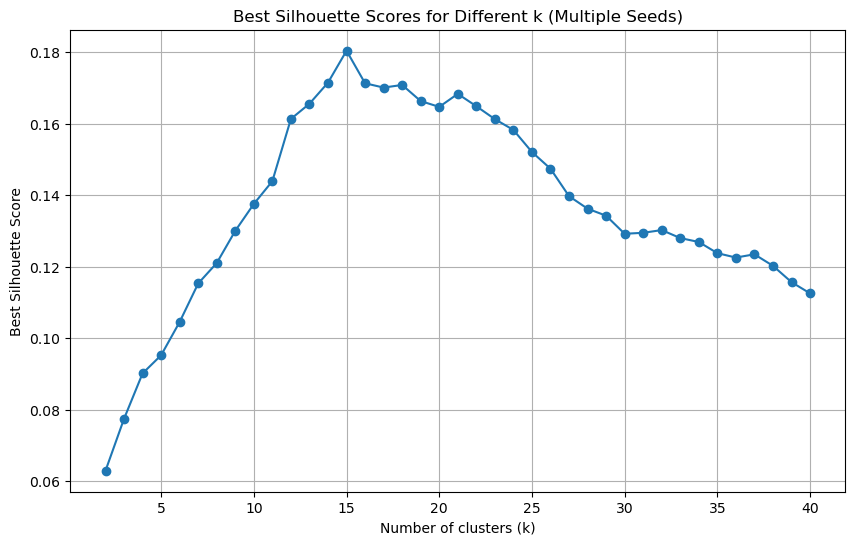

Optimal number of clusters: 15


In [41]:
optimal_k, best_labels, best_model = find_optimal_clusters_random(embeddings, max_k=40, n_init_passes=10)

# Apply cluster label to job list

In [42]:
print(Counter(best_labels))
clusterized_jobs_data = map_cluster_to_jobs_data(jobs_data, best_labels)

filename = f"clusterized_jobs_{job_data_version}.json"
save_path = DATA_JOBS_DIR / filename
save_json(save_path, clusterized_jobs_data)

Counter({np.int32(4): 23, np.int32(12): 22, np.int32(2): 20, np.int32(7): 17, np.int32(11): 14, np.int32(13): 13, np.int32(5): 11, np.int32(9): 10, np.int32(8): 10, np.int32(10): 10, np.int32(0): 10, np.int32(1): 10, np.int32(14): 10, np.int32(6): 10, np.int32(3): 10})


# Analyze cluster distribution

In [43]:
analyse_cluster_distribution(best_labels, job_list)

Cluster 7: accounting, banking, compliance, financial, risk
Cluster 9: case, contract, legal, research, statutory
Cluster 13: claims, compliance, insurance, regulatory, risk
Cluster 4: maritime, operations, port, safety, vessel
Cluster 12: equipment, live, operations, production, technical
Cluster 5: compliance, health, hse, industrial, safety
Cluster 8: chain, procurement, purchasing, supplier, supply
Cluster 11: electrical, electronics, systems, technical, work
Cluster 10: community, cultural, educational, programs, social
Cluster 2: guest, hotel, reception, service, tourism
Cluster 0: artistic, arts, creative, projects, visual
Cluster 1: cultural, information, management, records, systems
Cluster 14: design, development, innovation, projects, research
Cluster 6: fiber, manufacturing, paper, processes, production
Cluster 3: food, manufacturing, production, quality, safety


# Patch old clusters to new jobs file

In [24]:
import sys
sys.path.append('..')

from src.utils import (
    read_json,
    save_json
)

# Load jobs data
filename = f"clusterized_jobs_v3.json"
jobs_save_path = DATA_JOBS_DIR / filename
clusterized_jobs_data = read_json(jobs_save_path)

filename = f"extracted_jobs_{job_data_version}.json"
jobs_save_path = DATA_JOBS_DIR / filename
extracted_jobs_data = read_json(jobs_save_path)

filename = f"clusterized_jobs_{job_data_version}.json"
jobs_save_path = DATA_JOBS_DIR / filename
jobs_data = {}

for job_id in extracted_jobs_data:
    clusterized_job_data_dict = json.loads(clusterized_jobs_data[job_id])
    extracted_job_data_dict = json.loads(extracted_jobs_data[job_id])
    extracted_job_data_dict['domains'] = clusterized_job_data_dict['domains']
    extracted_job_data = json.dumps(extracted_job_data_dict, ensure_ascii=False)
    jobs_data[job_id] = extracted_job_data

save_json(jobs_save_path, jobs_data)